This notebook involves using CNN instead of mlp for the autoencoder and visualizing it using tsne and try to find its flaws

MNIST is used for training the architectures

Visualize the results on: https://wandb.ai/aniketthomas/Autoencoder

# Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch import nn
from torch import optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
from torchsummary import summary
from sklearn.manifold import TSNE
import wandb

# Helper

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def save_checkpoint(model, save_path):
    torch.save(model.state_dict(), save_path)
    
def load_checkpoint(model, save_path):
    model.load_state_dict(torch.load(save_path))
    return model

## Hyperparameters

In [3]:
batch_size = 64
input_vector_channel = 1

# Load Data

In [4]:
transform = transforms.Compose([#transforms.RandomHorizontalFlip(p = 0.5),
                                transforms.ToTensor(),
                                transforms.Normalize([0.5,], [0.5,])])
inv_transform = transforms.Compose([transforms.Normalize([0.,], [1/0.5,]),
                                   transforms.Normalize([-0.5,], [1.,])])
mnist_train = datasets.MNIST('data/', train = True, transform=transform, download=True)
mnist_val = datasets.MNIST('data/', train=False, transform=transform, download=True)
trainloader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
validloader = DataLoader(mnist_val, batch_size=batch_size, num_workers=8, pin_memory=True)

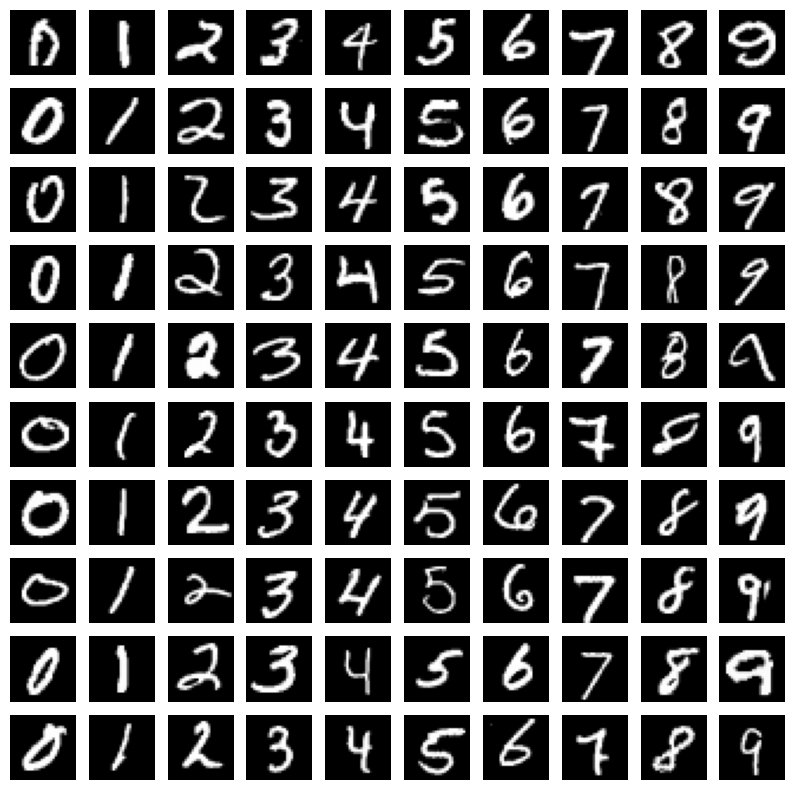

In [5]:
# Visualizing Data
train_images, train_labels = mnist_train.data, mnist_train.targets
unique_classes = np.unique(train_labels)
rows, cols = 10, len(unique_classes)
fig, axes = plt.subplots(rows, cols, figsize = (10,10))
i = 0
for _class in unique_classes:
    label_idx = np.where(train_labels == _class)[0]
    random_per_class = label_idx[np.random.choice(label_idx.shape[0], 10, replace = False)]
    for idx in random_per_class:
        img = train_images[idx]
        axes[i%10, i//10].imshow(img, cmap = 'gray')
        axes[i%10, i//10].axis('off')
        i+=1

# Vanilla Autoencoder

## Model

In [6]:
# Setting first experiment
wandb.init(project='Autoencoder', name="CNN based autoencoder")
num_filters = [32, 64]
latent_dim = 64
filter_size = 3
strides = [4, 2, 2]
learning_rate = 1e-02
num_epochs = 20
criterion = nn.MSELoss()
save_path = './saved_models/vanilla_cnn.pt'

wandb.config = {
    'batch_size': 64,
    'num_filters': num_filters,
    'latent_dim': latent_dim,
    'filter_size': filter_size,
    'strides': strides,
    'learning_rate': learning_rate,
    'num_epochs': num_epochs,
    'loss': 'mean_squared_error'
}

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: aniketthomas. Use `wandb login --relogin` to force relogin


In [7]:
class CNNAutoEncoder(nn.Module):
    def __init__(self, input_vector, num_filters, latent_dim, strides):
        super(CNNAutoEncoder, self).__init__()

        enc_list = []
        dec_list = []
        self.inp_dim = input_vector[0]
        all_units = input_vector + num_filters + latent_dim
        for i in range(len(all_units) - 1):
            temp = [nn.Conv2d(all_units[i], all_units[i+1], 3, strides[i]),
                    nn.BatchNorm2d(all_units[i+1]),
                    nn.ReLU()]
            enc_list.extend(temp)

        # Remove ReLU and batchnorm of last layer
        enc_list.pop()
        enc_list.pop()

        self.encoder = nn.Sequential(*enc_list)
        
        for i in range(len(all_units) - 1, 1, -1):
            temp = [nn.ConvTranspose2d(all_units[i], all_units[i-1], 3, strides[i-1]),
                    nn.BatchNorm2d(all_units[i-1]),
                    nn.ReLU()]
            dec_list.extend(temp)
        dec_list.extend([nn.ConvTranspose2d(all_units[i-1], all_units[i-2], 3, strides[i-2], output_padding=1)])
        dec_list.append(nn.Tanh())
        self.decoder = nn.Sequential(*dec_list)

    def forward(self, x):
        out = self.encoder(x)
        out = self.decoder(out)
        return out

In [8]:
cnn_autoencoder = CNNAutoEncoder([input_vector_channel], num_filters, [latent_dim], strides)
summary(cnn_autoencoder, (1, 28, 28));

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 1, 1]            --
|    └─Conv2d: 2-1                       [-1, 32, 7, 7]            320
|    └─BatchNorm2d: 2-2                  [-1, 32, 7, 7]            64
|    └─ReLU: 2-3                         [-1, 32, 7, 7]            --
|    └─Conv2d: 2-4                       [-1, 64, 3, 3]            18,496
|    └─BatchNorm2d: 2-5                  [-1, 64, 3, 3]            128
|    └─ReLU: 2-6                         [-1, 64, 3, 3]            --
|    └─Conv2d: 2-7                       [-1, 64, 1, 1]            36,928
├─Sequential: 1-2                        [-1, 1, 28, 28]           --
|    └─ConvTranspose2d: 2-8              [-1, 64, 3, 3]            36,928
|    └─BatchNorm2d: 2-9                  [-1, 64, 3, 3]            128
|    └─ReLU: 2-10                        [-1, 64, 3, 3]            --
|    └─ConvTranspose2d: 2-11             [-1, 32, 7, 7]            18,

In [10]:
def visualization(dataloader, model, title, clear = True):
    model.eval()
    tsne = TSNE(2)
    encoder = model.encoder
    decoder = model.decoder
    num_examples = {i:10 for i in range(10)}
    fig_1, axes_1 = plt.subplots(nrows = 10, ncols = 10, figsize = (10,10))
    fig_2, axes_2 = plt.subplots(nrows = 10, ncols = 10, figsize = (10,10))
    embed = []
    labels = []
    i = 0
    with torch.no_grad():
        pbar = tqdm(dataloader, total = len(dataloader), leave = False)
        for imgs, lbls in pbar:
            imgs, lbls = imgs.to(device), lbls.to(device)
            imgs_inp = imgs.view(-1, 1, 28, 28)
            embeddings = encoder(imgs_inp)
            out = decoder(embeddings)
            out = out.view(len(out), 1, 28, 28)
            embeddings = embeddings.view(len(out), -1)
            embed.extend(embeddings.cpu().detach().numpy().tolist())
            labels.extend(lbls.cpu().detach().numpy().tolist())
            for n in num_examples.keys():
                if num_examples[n] <= 0:
                    continue
                idxs = torch.where(lbls == n)[0][:num_examples[n]]
                num_examples[n] -= len(idxs)
                for idx in idxs:
                    idx = idx.item()
                    img = imgs[idx].detach().cpu().numpy()[0]
                    gen = out[idx].detach().cpu().numpy()[0]
                    axes_1[i//10, i%10].imshow(img, cmap = 'gray')
                    axes_1[i//10, i%10].axis('off')
                    axes_2[i//10, i%10].imshow(gen, cmap = 'gray')
                    axes_2[i//10, i%10].axis('off')
                    i+=1

    fig_3, axes = plt.subplots()
    embed = np.array(embed)
    labels = np.array(labels)
    color = plt.get_cmap('Spectral', 10)
    x_value = tsne.fit_transform(embed)
    scatter_plot = axes.scatter(x_value[:,0], x_value[:,1], c = labels, cmap = color)
    plt.colorbar(scatter_plot, drawedges = True, ax = axes)
    wandb.log({f"{title}_original": fig_1, f"{title}_regenerated":fig_2, f"{title}_visualization": wandb.Image(fig_3)})
    if clear:
        fig_1.clear()
        plt.close(fig_1)
        fig_2.clear()
        plt.close(fig_2)
        fig_3.clear()
        plt.close(fig_3)

visualization(trainloader, cnn_autoencoder, "Pre_Train")
visualization(trainloader, cnn_autoencoder, "Pre_Valid");

/home/thomas/.conda/envs/deep_learning/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/thomas/.conda/envs/deep_learning/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/thomas/.conda/envs/deep_learning/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/thomas/.conda/envs/deep_learning/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [11]:
def train_batch(imgs, model, criterion, optimizer, scaler, valid = False):
    optimizer.zero_grad()
    imgs, model = imgs.to(device, non_blocking = True), model.to(device)
    imgs = imgs.view(-1, 1, 28, 28)
    with torch.cuda.amp.autocast():
        out = model(imgs)
        batch_loss = criterion(out, imgs)
    if not valid:
        scaler.scale(batch_loss).backward()
        scaler.step(optimizer)
        scaler.update()
    return batch_loss.item()

def train(trainloader, validloader, model, criterion, optimizer, num_epochs, load_check = False, best_valid_metric = 0.0, 
          save_path = './saved_models/checkpoint.pt'):    
    # Load From checkpoing
    if load_check:
        model = load_checkpoint(model, save_path)

    scaler = torch.cuda.amp.GradScaler()
    train_losses, valid_losses = [], []
    for epoch in range(num_epochs+1):
        batch_loss = 0.0
        model.train()
        pbar = tqdm(trainloader, total = len(trainloader), leave = False)
        for imgs, _ in pbar:
            imgs = imgs.to(torch.float32)
            current_batch_loss = train_batch(imgs, model, criterion, optimizer, scaler)
            batch_loss += current_batch_loss
            pbar.set_postfix(train_loss = current_batch_loss)

        epoch_train_loss = batch_loss / len(trainloader)
        train_losses.append(epoch_train_loss)

        # Calculating for Valid data
        batch_loss = 0.0
        model.eval()
        pbar = tqdm(validloader, total = len(validloader), leave = False)
        with torch.no_grad():
            for imgs, _ in pbar:
                imgs = imgs.to(torch.float32)
                current_batch_loss = train_batch(imgs, model, criterion, optimizer, scaler, valid = True)
                batch_loss += current_batch_loss
                pbar.set_postfix(valid_loss = current_batch_loss)

        epoch_valid_loss = batch_loss / len(validloader)
        valid_losses.append(epoch_valid_loss)
        
        # Checkpoint
        if epoch_valid_loss < best_valid_metric:
            print('#### Saving ####')
            save_checkpoint(model, save_path)
            best_valid_metric = epoch_valid_loss
            
        wandb.log({'epoch':epoch ,'train_loss': epoch_train_loss, 'valid_loss': epoch_valid_loss})
        visualization(trainloader, cnn_autoencoder, "Epoch_train")
        visualization(validloader, cnn_autoencoder, "Epoch_valid")
        print(f"{'*'*10} EPOCH {epoch:2}/{num_epochs} {'*'*10}")
        print(f'''{"#"*33}
Train Loss: {epoch_train_loss:5.3f}
Valid Loss: {epoch_valid_loss:5.3f}
{"#"*33}''')
    return train_losses, valid_losses

In [ ]:
optimizer = optim.Adam(cnn_autoencoder.parameters(), lr = learning_rate)
train_losses, valid_losses = train(trainloader, validloader, cnn_autoencoder, criterion, optimizer, num_epochs, 
                                   best_valid_metric=999999, save_path=save_path)

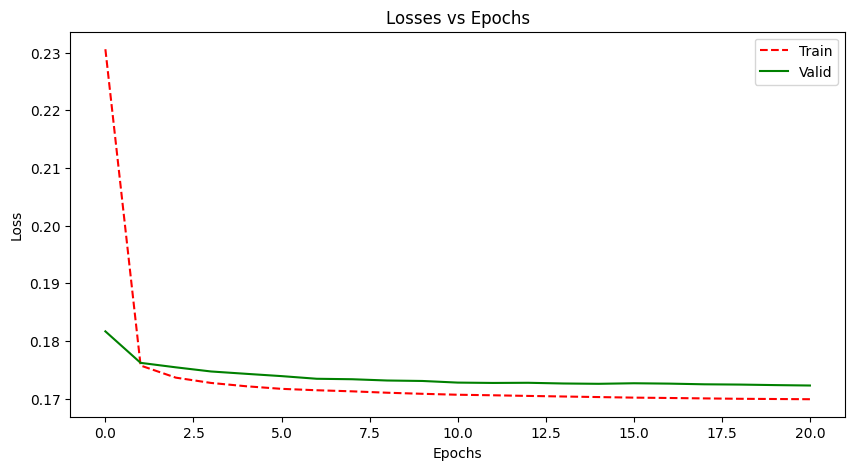

In [13]:
plt.figure(figsize = (10,5))
plt.title('Losses vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(train_losses, 'r--', label = 'Train')
plt.plot(valid_losses, 'g-', label = 'Valid')
plt.legend()
plt.show()

/home/thomas/.conda/envs/deep_learning/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/thomas/.conda/envs/deep_learning/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


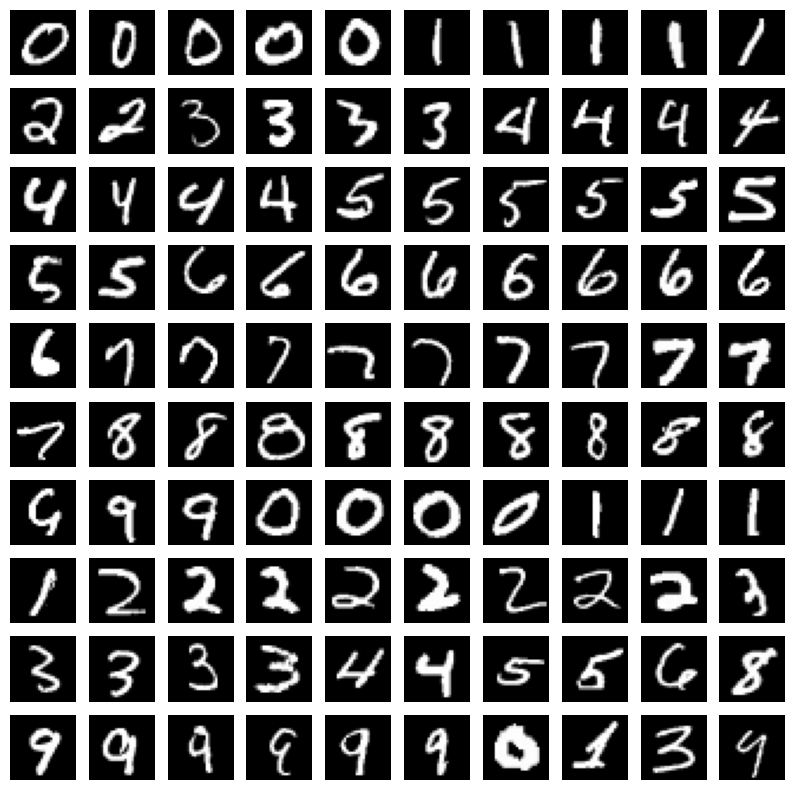

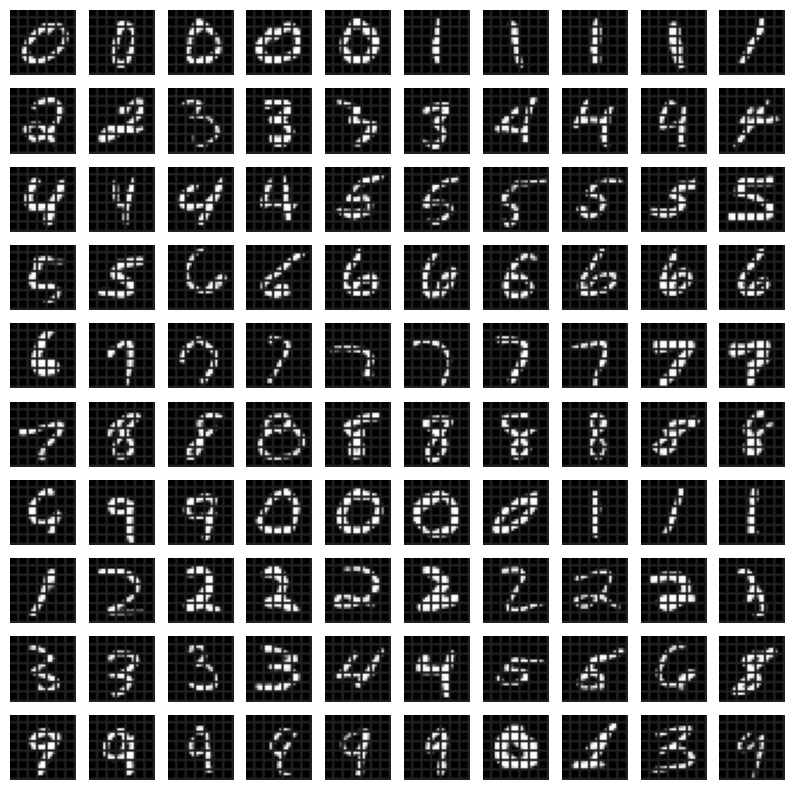

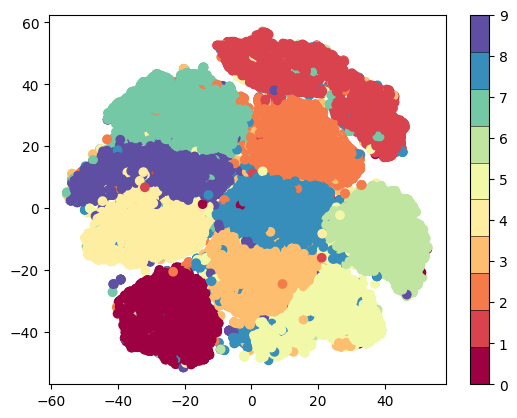

In [15]:
visualization(trainloader, cnn_autoencoder, "Post_train", clear = False)

/home/thomas/.conda/envs/deep_learning/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/thomas/.conda/envs/deep_learning/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


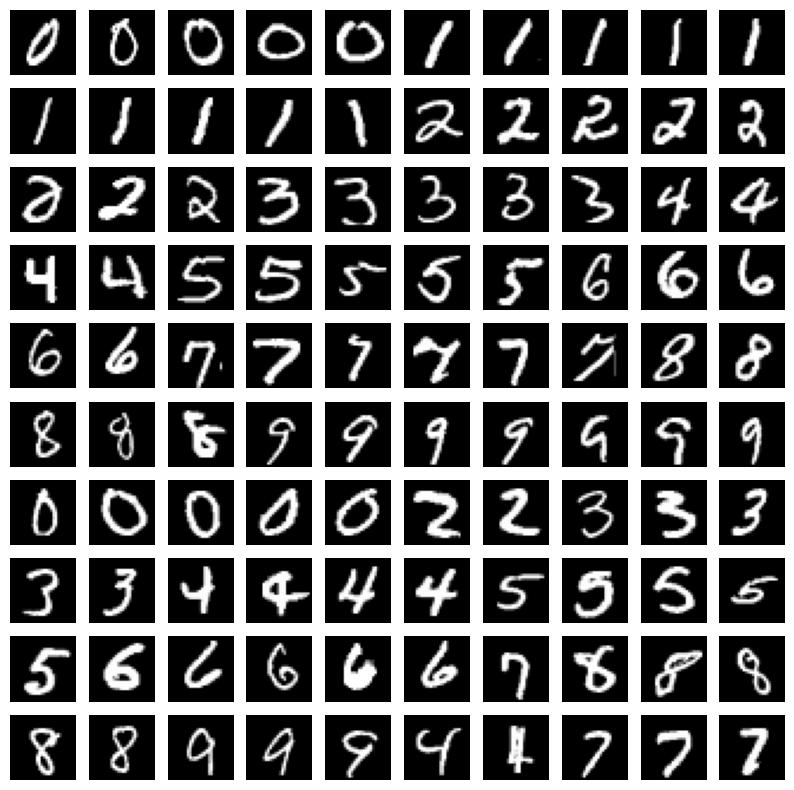

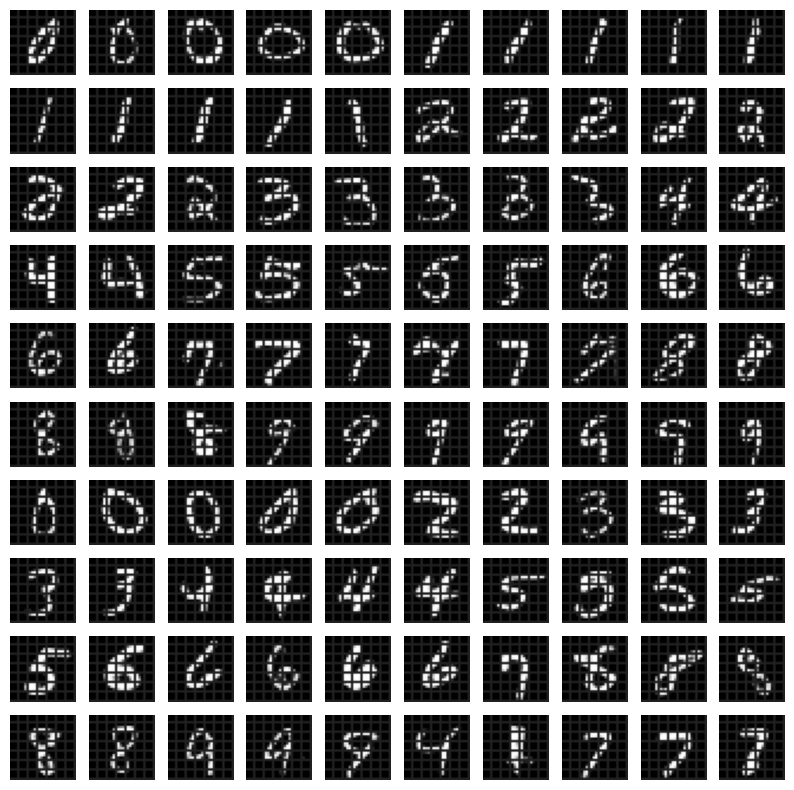

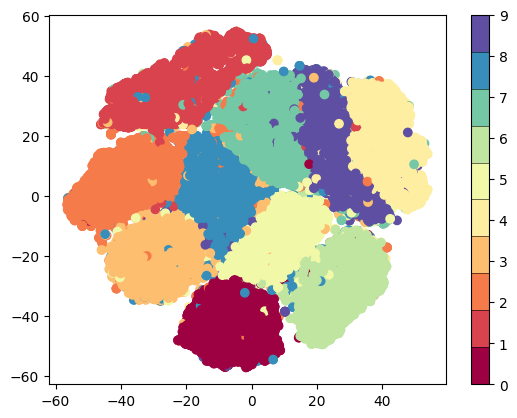

In [14]:
visualization(trainloader, cnn_autoencoder, "Post_valid", clear = False)

There are grid like patterns in image which can be corrected using some tweaking to the networks and the results are better separated and has better quality compared to the corresponding mlp architecture.